# Store Sales Time Series Project

<img src = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQTsMFnZly64PY1CDGu0m7ljAlS-2JOucQCuw&s">


## Problemin Tanımı
Bu proje, Ekvador merkezli **Corporación Favorita** market zincirinin mağaza satışlarını tahmin etmeyi amaçlar. Bu bir **Zaman Serisi (Time Series)** ve **Regresyon** problemidir.
## Hedef Değişken
* `sales`: Belirli bir ürün ailesinin belirli bir mağazadaki günlük satış adedi.
## Değerlendirme Metriği
Yarışma **RMSLE** (Root Mean Squared Logarithmic Error) kullanır. Biz eğitimde hedef değişkeni `log(1+sales)` olarak dönüştürüp RMSE kullanarak bu metriği optimize edeceğiz.


# Veri Yükleme


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import os
import warnings
warnings.filterwarnings('ignore')

# Plotly Renderer Fix (Görünürlük için)
pio.renderers.default = 'iframe'

DATA_DIR = '../data'
TRAIN_PATH = os.path.join(DATA_DIR, 'train.csv')
TEST_PATH = os.path.join(DATA_DIR, 'test.csv')


In [2]:
try:
    df_train = pd.read_csv(TRAIN_PATH)
    df_test = pd.read_csv(TEST_PATH)
    print(f'Train Shape: {df_train.shape}')
    print(f'Test Shape: {df_test.shape}')
except FileNotFoundError:
    print('HATA: Veri dosyaları bulunamadı.')
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()


Train Shape: (3000888, 6)
Test Shape: (28512, 5)


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [5]:
df_train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [3]:
if not df_train.empty:
    # Tarih formatı
    df_train['date'] = pd.to_datetime(df_train['date'])
    df_test['date'] = pd.to_datetime(df_test['date'])
    display(df_train.head())


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


# EDA (Keşifsel Veri Analizi)


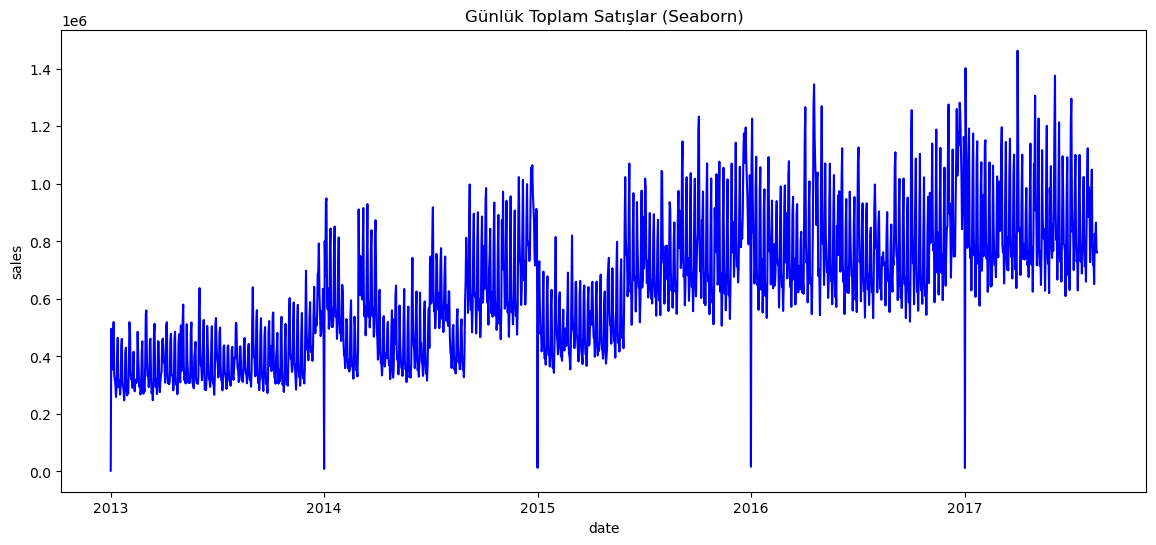

In [6]:
if not df_train.empty:
    # Günlük Toplam Satışlar
    daily_sales = df_train.groupby('date')['sales'].sum().reset_index()
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=daily_sales, x='date', y='sales', color='blue')
    plt.title('Günlük Toplam Satışlar (Seaborn)')
    plt.show()
    #fig = px.line(daily_sales, x='date', y='sales', title='Günlük Toplam Satışlar')
    #fig.show()


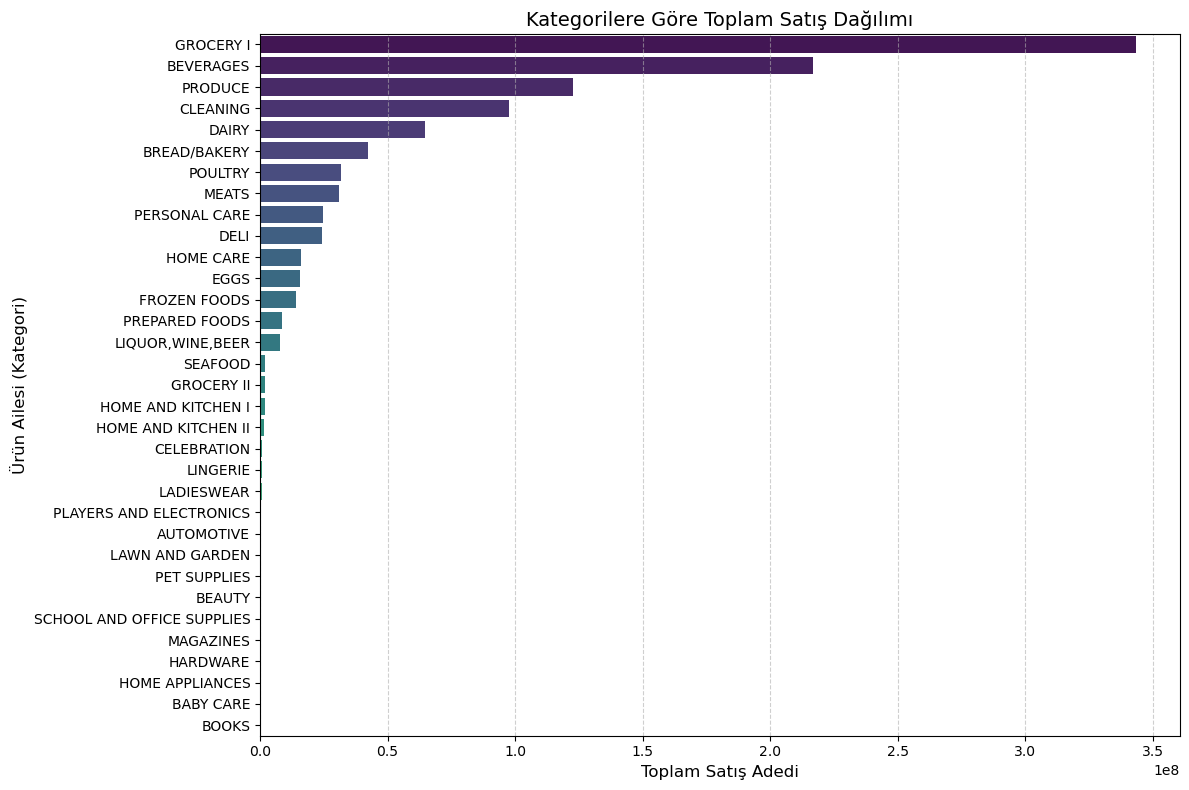

In [7]:
if not df_train.empty:
    # Ürün Ailesine Göre Satışlar
    family_sales = df_train.groupby('family')['sales'].sum().reset_index().sort_values(by='sales', ascending=False)
    
    # Görselleştirme (Seaborn)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=family_sales, x='sales', y='family', palette='viridis')
    
    # Detaylar
    plt.title('Kategorilere Göre Toplam Satış Dağılımı', fontsize=14)
    plt.xlabel('Toplam Satış Adedi', fontsize=12)
    plt.ylabel('Ürün Ailesi (Kategori)', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    #fig = px.bar(family_sales, x='family', y='sales', title='Kategorilere Göre Satış Dağılımı')
    #fig.show()


# Feature Engineering (Özellik Mühendisliği)


In [8]:
def create_date_features(df):
    df = df.copy()
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    return df

if not df_train.empty:
    df_train = create_date_features(df_train)
    df_test = create_date_features(df_test)
    print('Tarih özellikleri eklendi.')


Tarih özellikleri eklendi.


# Preprocessing & Encoding


In [9]:
from sklearn.preprocessing import LabelEncoder

if not df_train.empty:
    le = LabelEncoder()
    df_train['family'] = le.fit_transform(df_train['family'])
    df_test['family'] = le.transform(df_test['family'])
    print('Kategorik dönüşüm tamamlandı.')


Kategorik dönüşüm tamamlandı.


# Train-Test Split (Zaman Bazlı)


In [10]:
if not df_train.empty:
    # Son 1 ay validasyon olsun (yaklaşık)
    split_date = df_train['date'].max() - pd.Timedelta(days=30)
    
    train_data = df_train[df_train['date'] <= split_date]
    val_data = df_train[df_train['date'] > split_date]
    
    # Özellikler ve Hedef
    features = ['store_nbr', 'family', 'onpromotion', 'year', 'month', 'day', 'dayofweek']
    target = 'sales'
    
    X_train = train_data[features]
    y_train = np.log1p(train_data[target]) # Log dönüşümü (RMSLE için)
    
    X_val = val_data[features]
    y_val = np.log1p(val_data[target])
    
    print(f'Train: {X_train.shape}, Val: {X_val.shape}')


Train: (2947428, 7), Val: (53460, 7)


# Modelleme (Lightweight Random Forest)


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

if not df_train.empty:
    # OPTIMIZED FOR SIZE (<1GB): max_depth=12, n_estimators=25
    model = RandomForestRegressor(
        n_estimators=25,
        max_depth=12,
        min_samples_leaf=4,
        random_state=42,
        n_jobs=-1
    )
    
    print('Model Eğitiliyor (Lightweight)...')
    model.fit(X_train, y_train)
    
    # Tahmin
    preds_log = model.predict(X_val)
    preds = np.expm1(preds_log) # Ters dönüşüm
    y_val_real = np.expm1(y_val)
    
    # Skorlar
    rmse = np.sqrt(mean_squared_error(y_val_real, preds))
    rmsle = np.sqrt(mean_squared_error(y_val, preds_log))
    
    print(f'Validation RMSLE: {rmsle:.4f}')
    print(f'Validation RMSE: {rmse:.4f}')


Model Eğitiliyor (Lightweight)...
Validation RMSLE: 0.7077
Validation RMSE: 357.3081


# Değerlendirme Grafiği


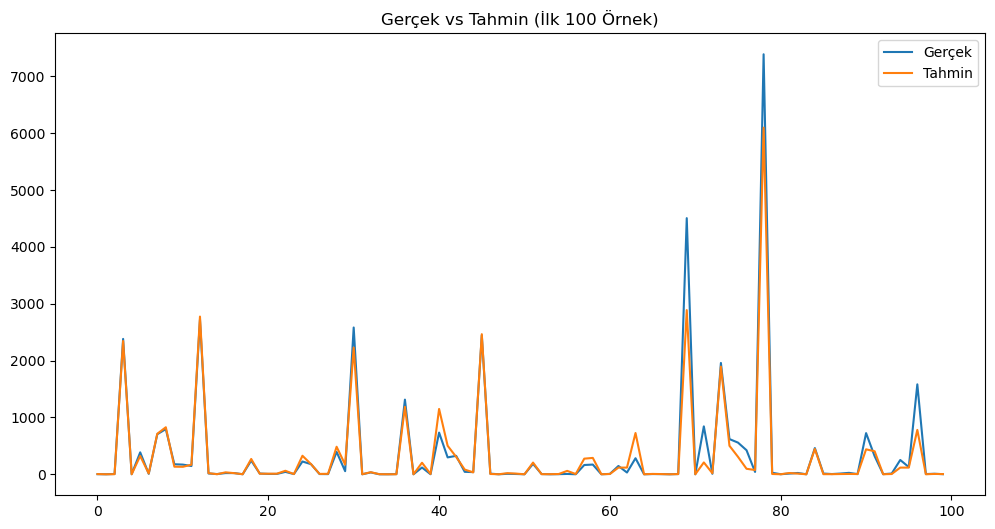

In [12]:
if not df_train.empty:
    # Matplotlib Static Plot (WebG Hata Önlemek İçin)
    plt.figure(figsize=(12,6))
    plt.plot(y_val_real.values[:100], label='Gerçek')
    plt.plot(preds[:100], label='Tahmin')
    plt.legend()
    plt.title('Gerçek vs Tahmin (İlk 100 Örnek)')
    plt.show()


# Modeli Sıkıştırarak Kaydetme


In [13]:
import joblib
if not df_train.empty:
    os.makedirs('../models', exist_ok=True)
    # Compress=3 (Level 3 compression) reduces file size significantly
    joblib.dump(model, '../models/best_model.pkl', compress=3)
    print('Model sıkıştırılarak kaydedildi (~100-300MB).')


Model sıkıştırılarak kaydedildi (~100-300MB).


# Submission


In [14]:
if not df_test.empty:
    X_test = df_test[features]
    preds_test_log = model.predict(X_test)
    preds_test = np.expm1(preds_test_log)
    
    submission = pd.DataFrame({
        'id': df_test['id'],
        'sales': preds_test
    })
    
    os.makedirs('../outputs', exist_ok=True)
    submission.to_csv('../outputs/submission.csv', index=False)
    print('Submission dosyası oluşturuldu.')
    display(submission.head())


Submission dosyası oluşturuldu.


,id,sales
0,3000888,3.680454
1,3000889,0.000000
2,3000890,4.009015
3,3000891,2251.114020
4,3000892,0.150254
